# Eksperimenter med FED data

- **Problem:** Kan jeg med ML finde FED overskrifter, som giver 10 eller flere strategilinjer? Mine input data er FED data, hvor jeg har samlet en overskrift og det tilhørende *antal* linjer strategi hørende til overskriften. Dette er et binary problem: over eller under 10 linjer
- **Succes er** Jeg vil se hvor mange af de store (10 eller flere strategilinjer) som modellen kan finde i test data. JEg håber på halvdelen, men er usikker, for jeg kan ikke selv se et mønster ...
- **Evaluering** Modellen evalueres ved at jeg deler data op i train, validering og test. train og validering opdeles atomatisk af Keras
- **Data** hentes ud af FED i en tekst-fil. Den videre behandling sker i en Access-database og i et regneark. Input gemmes til sidst i et regneark
- **Baseline** Selv den bedste model har ikke rigtigt gjort det godt ind til nu, der er nok ikke system i data? Reelt kan den ikke skelne de to klasser, se histogrammet nederst ...
- **Optimering vs generalisering** Modellen overfitter ret hurtigt, uden at den egentligt på noget tidspunkt bliver god ...
- **Tuning hyper pametre** Jeg prøver med flere og færre lag, typer af lag, dropout, parametre mv, men det virker ikke meget bedre ... 

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. Og den timsvarende omsættelse til inddata til modellen.

![title](FEDentry.GIF)
![title](FEDentry2.GIF)

### Konklusion
- Endnu en version som har svært ved at fungere helt godt ...

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')


In [2]:
# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
StorEr = 10
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values
labels = np.asarray([1*(NumLines[i]>=StorEr) for i in range(len(NumLines))])

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
labels = labels[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 90000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
labels_train = labels[:i]
labels_test  = labels[i:]
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [3]:
# laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Stop sætninger efter dette antal ord
maxlen = 50

# sætninger laves til tekst-vektor og der "paddes"
sequences = tokenizer.texts_to_sequences(texts_train)
data_train = pad_sequences(sequences, maxlen=maxlen)
sequences = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences, maxlen=maxlen)

# labels laves til vektor
labels_train = np.asarray(labels_train).astype('float32')
labels_test = np.asarray(labels_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(90000, 50)
(10867, 50)
(90000,)
(10867,)


In [5]:
#from keras import models
#from keras import layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())                               # dim = samples, (maxlen * 8)
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model.summary()

In [6]:
NumEpochs = 20
history = model.fit(data_train, labels_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.1)

Train on 81000 samples, validate on 9000 samples
Epoch 1/20
81000/81000 [==============================] - 6s 70us/step - loss: 0.2457 - acc: 0.9560 - val_loss: 0.1413 - val_acc: 0.9651
Epoch 2/20
81000/81000 [==============================] - 1s 13us/step - loss: 0.1711 - acc: 0.9620 - val_loss: 0.1228 - val_acc: 0.9651
Epoch 3/20
81000/81000 [==============================] - 1s 13us/step - loss: 0.1524 - acc: 0.9621 - val_loss: 0.1188 - val_acc: 0.9653
Epoch 4/20
81000/81000 [==============================] - 1s 13us/step - loss: 0.1431 - acc: 0.9624 - val_loss: 0.1180 - val_acc: 0.9656
Epoch 5/20
81000/81000 [==============================] - 1s 13us/step - loss: 0.1375 - acc: 0.9627 - val_loss: 0.1181 - val_acc: 0.9653
Epoch 6/20
81000/81000 [==============================] - 1s 13us/step - loss: 0.1322 - acc: 0.9629 - val_loss: 0.1182 - val_acc: 0.9653
Epoch 7/20
81000/81000 [==============================] - 1s 13us/step - loss: 0.1283 - acc: 0.9635 - val_loss: 0.1193 - val_acc:

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [8]:
import matplotlib.pyplot as plt
plt.show()

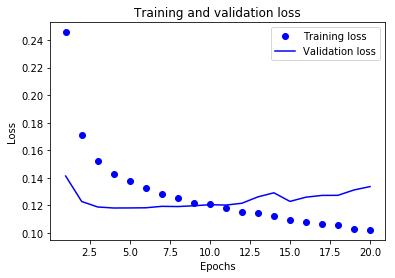

In [9]:
# plotter historikken for 'loss' og 'accuracy'
accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

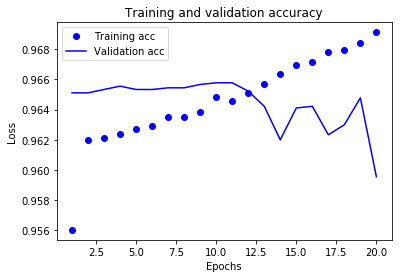

In [10]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [11]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)

In [12]:
# finder ud af hvor stor en del store, som er fundet
print('Antal store i datasættet:    ', sum(labels_test))
NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.4 and labels_test[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     400.0
antal estimeret af modellen:  68
Modellens præcision:          17.0 %


In [13]:
# Gennemsnittet for rigtig og forkert

print(' Gennemsnit for test stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels_test[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels_test[i]]))

 Gennemsnit for test stor og lille
0.2786728
0.047764864


In [14]:
# jeg prøver at printe linjenummer, prediction og tekststreng for dem som er store = "rigtige"

print('Jeg printer nogle liner som er sande i test data, vi ser hvordan de predicter:')
print('-'*40)
print('Lines Predict Text')
for i in range(1,900):
    if labels_test[i]==1:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Jeg printer nogle liner som er sande i test data, vi ser hvordan de predicter:
----------------------------------------
Lines Predict Text
   10  0.0237  materielfejl
   15  0.4042  Sprængning af højhuse i Rødovre vil stoppe trafikken mellem 12 - 12 40 ca
   10  0.0562  materielfejl dørfejl holder i ØRE
   17  0.3139  Materielfejl, røgudvikling fra toget, holder i spor 2 på Kh.
   51  0.1767  OBS: Ændringer for resten af påsken, omkring vendingerne i Lk 19/4.
   13  0.2821  Sporskiftefejl Køge.
   12  0.1706  problemer med MG bremsen holder i VY
   11  0.1551  fjernstyringsfejl i SU Se Drap 1959966
   22  0.4876  Falsk besættelse  Phm Svenskerne har opgivet at lave det, da det skyldes fugt (!)
   13  0.2377  Blokfejl nr 2022 fra Østerport mod Kh.
   10  0.0098  Der mgl ER til 917,4109,810. Flg disponeres :
   10  0.2466  Nedformeringer fra Sverige.
   11  0.0030  Materielfejl MG i Sd, dørfejl, trin vil ikke gå ind. K -52 U
   11  0.3129  DSB disponering. Vi mangler MF på Sjælland - og 

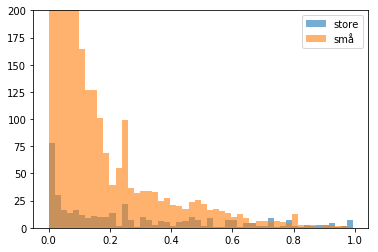

In [15]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_test[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_test[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små')
plt.legend(loc='upper right')
plt.ylim([0, 200])

plt.show()

In [16]:
# hvilke tekster de forskellige typer består af
print('SANDE i test-sættet, som har SMÅ predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==1 and predictions[i] < 0.05:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()
        
print('SANDE i test-sættet, som har STORE predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==1 and predictions[i] > 0.5:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()

print('FALSKE i test-sættet, som har STORE predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==0 and predictions[i] > 0.5:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()

SANDE i test-sættet, som har SMÅ predictions (men burde være store!):
----------------------------------------
Lines Predict Text
   10  0.0237  materielfejl
   10  0.0098  Der mgl ER til 917,4109,810. Flg disponeres :
   11  0.0030  Materielfejl MG i Sd, dørfejl, trin vil ikke gå ind. K -52 U
   14  0.0199  (Skrevet 13/11 kl. 19:30) Vi mangler 4-5 MF´ere til morgentrafikken.. Desuden er 4103 og resten 
   14  0.0015  Lki melder at den har smidt kølevandet i den ene ende, der køres på 1 motor
   10  0.0427  Mgl MQ i Od og i FA
   10  0.0458  Gået i stå lige før Hk. Li sat på sagen
   10  0.0064  Tog 6100 (Railcare) har problemer med ATC i Rq. IC 916 fanget bagved.
   11  0.0081  Mangel på MG / ER / Vogne. / Stv.
   11  0.0154  Disponering DSB, placering af ET til Vk mm.
   13  0.0238  Er minus fra Øst. K -16 Ng.
   14  0.0001  Materielfejl ABS : def førerstol
   18  0.0066  Vi mangler 6 ER til eftermiddagstrafiken. Vi får intet klart fra Hgl.
   10  0.0467  Disponering DSB, grundet for

UHA UHA, alt for mange af de sande har en værdi tæt på 0 ...